In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm

In [ ]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [ ]:
# file  = "HS_front_RH50_PR0_PRRELAX86400_day0_500_all.dat"
file  = "HS_front_RH80_PR10_PRRELAX86400_with_w_all.dat"

ds = h5py.File(file, "r")
print(ds.keys())

print(np.nanmax(np.asarray(ds["grid_w_full_xyzt"])))
dycore = Dycore(file)
u  = dycore.getVar("grid_u_c_xyzt")
test = np.zeros(u.shape)
print(test.shape)

In [ ]:
def plot_V_W_50(pr):
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    # u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1])
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,19):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(1,63):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0

In [ ]:
import cmaps
vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)

In [ ]:
from EOF import EOF
from scipy.fft import fft, ifft
u_50 = dycore.getVar("grid_u_c_xyzt")
u_50 = np.nanmean(u_50[:,:,:,:], axis=(1,3))

# u_50_new = (u_50 - u_50.mean()) / u_50.std()
# print(u_50_new.shape)
# u_50_new = np.nanmean(u_50_new, axis=1)x
# single_EOF_50 =  EOF((u_50_new[:,],), n_components=10, field="1D")
# single_EOF_50.get()
try_50_low, _, EOF_50_low =  np.linalg.svd(u_50[:,:])
z = try_50_low[:,0]
# z = (single_EOF_50.PC[:,1])

# Z = fft(z)
# print(Z.shape)
# print(z.shape)

# EP flux dot EOF(y)^T mean EP flux projecting on the EOF(y) axis
plt.plot(EOF_50_low[0,:])
print(EOF_50_low[0,:].shape)
print(z.shape)



In [ ]:
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
y = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)

v  = dycore.getVar("grid_v_c_xyzt")
u  = dycore.getVar("grid_u_c_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
t  = dycore.getVar("grid_t_c_xyzt")
Rd = 287
cp = 1004
H  = (287*280/9.81)

theta = t * (ps / p)**(Rd/cp)
x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

Vza = np.zeros(u.shape)
Uza = np.zeros(u.shape)
THETAza = np.zeros(u.shape)
    
Vzm = np.nanmean(v, axis=3)
Uzm = np.nanmean(u, axis=3)
THzm = np.nanmean(theta, axis=3)
for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    THETAza[:,:,:,i] = theta[:,:,:,i] - THzm

zeta = np.zeros(u.shape)
pvpx = np.zeros(u.shape) # mean partial v over partial x 
pupy = np.zeros(u.shape)
for i in range(1, 128-1):
    pvpx[:,:,:,i] = (Vza[:,:,:,i+1] - Vza[:,:,:,i-1]) / (xd[i+1] - xd[i-1])
pvpx[:,:,:,0]  = (Vza[:,:,:, 1] - Vza[:,:,:, 0]) / (xd[1] - xd[0])
pvpx[:,:,:,-1] = (Vza[:,:,:,-1] - Vza[:,:,:,-2]) / (xd[-1] - xd[-2])

for i in range(1, 64-1):
    pupy[:,:,i,:] = (Uza[:,:,i+1,:] - Uza[:,:,i-1,:]) / (yd[i+1] - yd[i-1])
pupy[:,:, 0,:]  = (Uza[:,:, 1,:] - Uza[:,:, 0,:]) / (yd[1] - yd[0])
pupy[:,:,-1,:]  = (Uza[:,:,-1,:] - Uza[:,:,-2,:]) / (yd[-1] - yd[-2])

zeta = pvpx - pupy

lat = np.linspace(-90,90,64)
# print(lat)
f0  = 2 * 7.292E-5 * np.sin(np.deg2rad(lat))
### FIX ME
bza = np.zeros(u.shape)
# for i in range(0,20):
bza[:,:,:,:] = THETAza[:,:,:,:] / np.nanmean(theta[:,0,:,:], axis=0) * 9.81

N_square   = np.zeros(u.shape)
for i in range(1,20-1):
    delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,i+1,:,:])
    delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,i-1,:,:])
    delta_z  = -abs(delta_z1 - delta_z2)
    # print((theta[:,i+1,:,:] - theta[:,i-1,:,:]))
    N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / delta_z # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,1,:,:])
delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,0,:,:])
delta_z  = -abs(delta_z1 - delta_z2)
N_square[:, 0,:,:] = 9.81 / theta[:, 0,:,:] * (theta[:, 1,:,:] - theta[:, 0,:,:]) / delta_z
delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,-1,:,:])
delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,-2,:,:])
delta_z  = -abs(delta_z1 - delta_z2)
N_square[:,-1,:,:] = 9.81 / theta[:,-1,:,:] * (theta[:,-1,:,:] - theta[:,-2,:,:]) / delta_z

q1 = zeta
q2 = np.zeros(u.shape)
ff = bza / N_square
for i in range(1,20-1):
    delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,i+1,:,:])
    delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,i-1,:,:])
    delta_z  = -abs(delta_z1 - delta_z2)
    # print(np.nanmax(delta_z))
    q2[:,i,:,:] = (bza[:,i+1,:,:] - bza[:,i-1,:,:])  / delta_z / (N_square[:,i+1,:,:] - N_square[:,i-1,:,:]) # / N_square[:,i,:,:]
delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,1,:,:])
delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,0,:,:])
delta_z  = -abs(delta_z1 - delta_z2)
q2[:,0,:,:]  = (bza[:, 1,:,:] - bza[:, 0,:,:])  / delta_z / (N_square[:, 1,:,:] - N_square[:, 0,:,:]) # / N_square[:,0,:,:] 
delta_z1 = H * np.log(ps[:,0,:,:] /  p[:,-1,:,:])
delta_z2 = H * np.log(ps[:,0,:,:] /  p[:,-2,:,:])
delta_z  = -abs(delta_z1 - delta_z2)
q2[:,-1,:,:] = (bza[:,-1,:,:] - bza[:,-2,:,:])  / delta_z  / (N_square[:,-1,:,:] - N_square[:,-2,:,:]) # / N_square[:,-1,:,:]

for j in range(0, 64):
    q2[:,:,j,:] *= f0[j]

qza = q1 + q2
print(qza.shape)
print(Vza.shape)
pupt = f0 * vTEM + np.nanmean(Vza * qza, axis=(3))
print(pupt.shape)
print(vTEM.shape)
print(yy.shape)
print(sigma_mean2.shape)
print(Vza.shape)



In [ ]:
### plot for check 
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
y = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
#
plt.contourf(yy[:,:], sigma_mean2[:,:], np.nanmean(N_square, axis=(0,3)), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
#
plt.figure(dpi=100.)
plt.contourf(yy[:,:], sigma_mean2[:,:], np.nanmean(bza, axis=(0,3)), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()

[[ -28.71108112  -24.09204827   -0.19765676 ...  -22.85558619
   -33.23357973  -36.93305717]
 [ -25.12156462  -34.04135156  -13.51014266 ...  -11.26218019
   -27.76207143  -31.47361399]
 [ -39.30684681  -38.23315558   -8.1635642  ...   11.53336146
    -7.33486654  -13.46916567]
 ...
 [  53.9958423    20.35237026  -11.61665321 ...   -0.64347616
   -96.27835333 -127.42488601]
 [ -46.09736121  -39.84277592  -15.06739906 ...   36.35415264
    17.630528    -10.79539235]
 [-125.19681537  -83.89188982   14.18076332 ...   67.55568351
    77.52911031   67.21745976]]


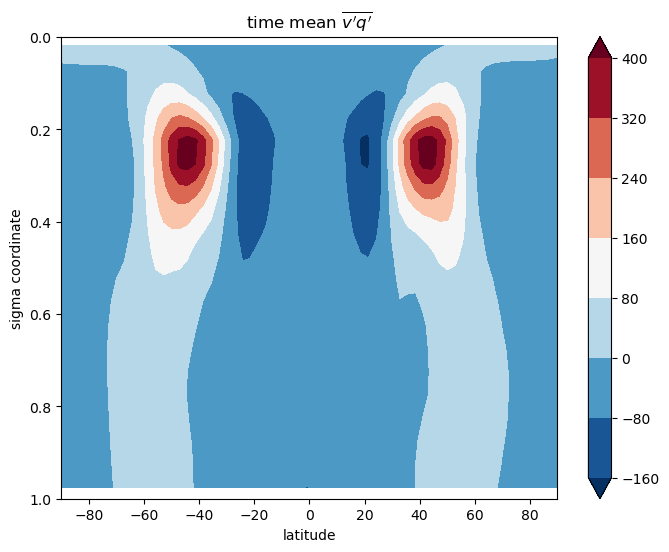

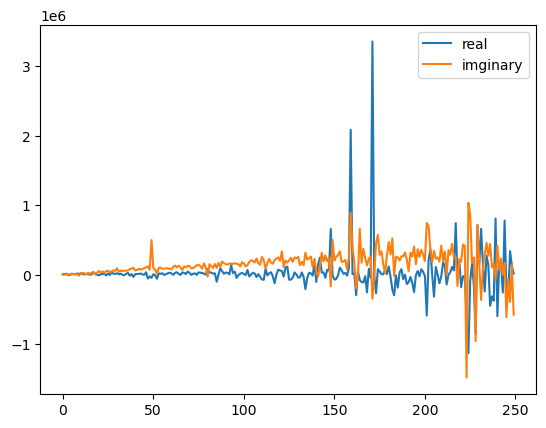

In [27]:
### FIX ME
from scipy.fftpack import fft,ifft,fftfreq
EP_flux =  np.nanmean(Vza[:,:,:,:] * qza[:,:,:,:], axis=(1,3)) + f0 * np.nanmean(vTEM, axis=0)
print(EP_flux)
m = np.dot(EP_flux, EOF_50_low[0,:])
# print(EOF_50_low[1,:].T.shape)
Max_mode = 250
x = np.linspace(-np.pi,np.pi,Max_mode*2+1)[:-1]   #x位置
#### FFT ####
M = fft(m)/len(m)    #要除以資料長度
Z = fft(z)/len(z)    #要除以資料長度

Z_star = np.conjugate(Z)
M_star = np.conjugate(M)

final = (Z_star * M) / (Z_star * Z) 

freq = fftfreq(n=len(M), d=1/500)
# plot
### plot for check 
sigma_mean = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
y = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
#
plt.figure(figsize=(8,6), dpi=100.)
plt.contourf(yy[:,:], sigma_mean2[:,:], np.nanmean(Vza[:,:,:,:] * qza[:,:,:,:], axis=(0,3)) + f0 * np.nanmean(vTEM, axis=0), cmap="RdBu_r", extend="both")
plt.ylim([1,0])
plt.colorbar()
plt.title("time mean $\overline{v'q'}$")
plt.xlabel("latitude")
plt.ylabel("sigma coordinate")
# plt.savefig(r"paper1_fig/eq(7.64a)_fig/RH50_PR10/v'q'_mean_time.png", bbox_inches='tight', dpi=600.)
##################
a = 6.37122e6

plt.figure(dpi=100.)
plt.plot(freq[0:250],final.real[0:250], label="real")
plt.plot(freq[0:250],final.imag[0:250], label="imginary")
# plt.plot(freq,final.real, label="real")

# print(final)
# plt.plot(x[250:315]/np.pi,x[250:315]*2*np.pi, label="2*pi*freq")
plt.legend()

In [ ]:
x = 1 + 3j
xx = np.conjugate(x)
print(x.imag)
print(xx)


In [ ]:
x = np.linspace(-np.pi,np.pi,Max_mode*2+1)[:-1]   #x位置
t = np.arange(500)
freq = fftfreq(t.shape[-1])
# plt.plot(freq,  (Z).real)
# plt.plot(freq,  (Z).imag)
# plt.plot(freq[0:int(500/4)],  (Z_star[0:int(500/4)]).real)
# plt.plot(freq[0:int(500/4)],  (Z[0:int(500/4)]).real)
# plt.plot(freq[0:int(500/4)],  (Z_star[0:int(500/4)]).imag)
# plt.plot(freq[0:int(500/4)],  (Z[0:int(500/4)]).imag)
plt.plot(freq,  ((Z*Z_star)).real)
plt.plot(freq,  ((Z*Z_star)).imag)

# print(Z)
# plt.plot(freq[:250],  (M[:250]).real)

# plt.plot(freq,  ((M*Z_star)).imag)
# plt.plot(freq,  (1/(Z*Z_star)).real)


# plt.plot(freq[0:int(500/4)],  (final[0:int(500/4)]).imag)

# plt.plot(x/np.pi, 2/500 * (Z).imag)

# plt.ylim([-100000,100000])
# plt.xlim([0,0.25])
# plt.plot(x, z)


In [ ]:
momentum = np.nanmean(Uza * Vza, axis=(1,3))
print(momentum.shape)
cy = np.cos(yd)
cm = cy**2 * momentum
print(cm.shape)
pmpu = np.zeros((500,64))
for i in range(1,64-1):
    pmpu[:,i] = (cm[:,i+1] - cm[:,i-1]) / (yd[i+1] - yd[i-1])
pmpu[:,0] = (cm[:,1] - cm[:,0]) / (yd[1] - yd[0])
pmpu[:,-1] = (cm[:,-1] - cm[:,-2]) / (yd[-1] - yd[-2])
a = 6.37122e6
final_m_term = - pmpu / (a * cy**2)


In [ ]:
m = np.dot(final_m_term, EOF_50_low[0,:].T)
M = fft(m) / len(m)
print(m.shape)
print(EOF_50_low.shape)
print(M.shape)
M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final = (Z_star * M) / (Z_star * Z)
plt.figure(dpi=100.)
plt.plot(freq[0:250],final.real[0:250], label="real")
plt.plot(freq[0:250],final.imag[0:250], label="imginary")
